In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir("/content/drive/MyDrive/code/growth")
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/ベイズ（論文2）/投稿用code/growth'

In [ ]:
import pystan
from pystan import StanModel
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['font.sans-serif'] = ['Arial'] 
from scipy import stats
import math
import pickle

In [ ]:
#data    
data = pd.read_csv("data/24cell.csv")
time = data['TIME']
N = data['Nt']
N_new = N *(10 ** data['Dilution'])
data['N_new'] = N_new

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
#import fitting result
with open('data/model-growth.pkl','rb') as f:
    model = pickle.load(f)
with open('data/result-growth.pkl','rb') as g:
    fit_nuts = pickle.load(g)
mu = fit_nuts['mu']
lag = fit_nuts['lag']

In [ ]:
#time for prediction
T = []
for i in range(211):
    t = i * 0.05
    T.append(t)

In [ ]:
N0_mean = 24 #initial cell number (average)

#prediction interval
y_pred_int = np.zeros((len(mu),len(T)))
for i in range(len(mu)):
    N0 = np.random.poisson(N0_mean)
    for j in range(len(T)):
        if N0 == 0:
            y_pred_int[i,j] = 0
        elif  0 <= N0/(N0*math.exp(mu[i]*(T[j]-lag[i]))) <= 1:
            y_pred_int[i,j] = N0 + np.random.negative_binomial(N0, N0/(N0*math.exp(mu[i]*(T[j]-lag[i]))), size=1)
        else:
            y_pred_int[i,j] = N0

y_pred_upper0 = y_pred_int[y_pred_int[:,0] != 0]
y_pred_upper0_975 = np.percentile(y_pred_upper0, 2.5, axis=0)
y_pred_upper0_025 = np.percentile(y_pred_upper0, 97.5, axis=0)
y_pred_upper0_500 = np.percentile(y_pred_upper0, 50.0, axis=0)
y_pred = np.log10(y_pred_upper0)
y_pred_975 = np.percentile(y_pred, 2.5, axis=0)
y_pred_025 = np.percentile(y_pred, 97.5, axis=0)
y_pred_500 = np.percentile(y_pred, 50.0, axis=0)


In [ ]:
#confidence interval
y_conf_int = np.zeros((len(mu),len(T)))
for i in range(len(mu)):
    N0 = N0_mean
    for j in range(len(T)):
        if N0 == 0:
            y_conf_int[i,j] = 0
        elif  0 <= N0/(N0*math.exp(mu[i]*(T[j]-lag[i]))) <= 1:
            y_conf_int[i,j] = N0*(math.exp(mu[i]*(T[j]-lag[i])))
        else:
            y_conf_int[i,j] = N0

y_conf_upper0 = y_conf_int[y_conf_int[:,0] != 0]
y_conf_upper0_975 = np.percentile(y_conf_upper0, 2.5, axis=0)
y_conf_upper0_025 = np.percentile(y_conf_upper0, 97.5, axis=0)
y_conf_upper0_500 = np.percentile(y_conf_upper0, 50.0, axis=0)
y_conf = np.log10(y_conf_upper0)
y_conf_975 = np.percentile(y_conf, 2.5, axis=0)
y_conf_025 = np.percentile(y_conf, 97.5, axis=0)
y_conf_500 = np.percentile(y_conf, 50.0, axis=0)


In [ ]:
#accuracy
Time = [0,2,4,6,8,10] #time for prediction (h)
i = [0,1,2,3,4,5]
num = [50,50,50,50,48,50] #number of data
evaluation =[]
ZERO = []
for t,i in zip(Time,i):
    T1 = int(t/0.05)
    y_pred_min = y_pred_upper0_975[T1]
    y_pred_max = y_pred_upper0_025[T1]
    hani =[]
    repetition = num[i]
    for j in range(repetition):
        number = sum(num[0:i])+j
        N = N_new[number]
        if N == 0:
            ans = 2
        elif y_pred_min <= N <= y_pred_max :    
            ans= 1
        else:
            ans=0
        hani.append(ans)
    correct =hani.count(1)
    zero = hani.count(2)
    ZERO.append(zero)
    evaluation.append(correct)
accuracy = (sum(evaluation)/(sum(num)-sum(ZERO)))*100


Text(1.0, 4.8, '(A)')

<Figure size 432x288 with 0 Axes>

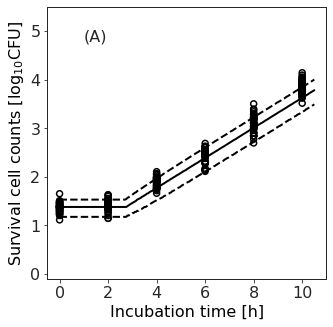

In [ ]:
#graph
fig = plt.figure()
plt.style.use('ggplot')
sns.set_style(style='ticks')
plt.figure(figsize=(5,5))
plt.ylabel('Survival cell counts [$\log_{10}$CFU]',fontsize=16, color='k')
plt.xlabel('Incubation time [h]', fontsize=16, color='k')
plt.tick_params(labelsize=16, direction='out')
plt.xlim(-0.5,11)
plt.ylim(-0.1,5.5)
plt.xticks([0,2,4,6,8,10])
plt.scatter(time, np.log10(N_new), zorder=2, facecolors ='none',edgecolors='k',linewidth=1.5)

#prediction interval
plt.plot(T,y_pred_025, linestyle = 'dashed', zorder=2, color='black', lw=2.0)
plt.plot(T,y_pred_975, linestyle = 'dashed', zorder=2, color='black', lw=2.0)
plt.plot(T,y_pred_500, linestyle = 'solid', zorder=1, color='black', lw=2.0)

plt.text(1.0,4.8, '(A)', fontsize=16)

In [ ]:
accuracy

80.20134228187919